# Radial Basis Function #

References:
* http://www.jessebett.com/Radial-Basis-Function-USRA/
* http://www.scholarpedia.org/article/Radial_basis_function
* http://scribblethink.org/Courses/ScatteredInterpolation/scatteredinterpcoursenotes.pdf

$$
f(x) = \sum_k^N{w_k\phi(\vert\vert{x-x_k}\vert\vert)}
$$

The conditions of interpolating the avaliable data can be written as

$$
f(x_i) = \sum_k^N{w_k\phi(\vert\vert{x_i-x_k}\vert\vert)} = f_i, \text{for } 1 \leq i \leq n
$$

This is a linear system of equations where the unknowns are the vector of weights ${w_k}$. To see this, let us call $\phi_{i,k} = \phi(\vert\vert{x_i-x_k}\vert\vert)$. We can then write the equivalent matrix representation of the interpolation conditions:

$$
\begin{bmatrix}
\phi_{1,1} & \phi_{1,2} & \phi_{1,3} & \dots \\ 
\phi_{2,1} & \phi_{2,2} & \dots \\
\phi_{3,1} & \dots \\
\vdots
\end{bmatrix}
\begin{bmatrix} 
w_1 \\
w_2 \\
w_3 \\
\vdots
\end{bmatrix} = 
\begin{bmatrix} 
f_1 \\
f_2 \\
f_3 \\
\vdots
\end{bmatrix}
$$

This is a square system with as many equations as unknowns. Thus we can
form the radial basis function interpolation by solving this system of equations

### Kernels ###

* Linear
$$
f(r) = 
\begin{cases}
    1-\frac{r}{c}, & \text{if } r < c \\
    0, & \text{otherwise}
\end{cases}
$$

* Gaussian
$$
f(r) = e^{-\frac{r^2}{2c^2}}
$$

* Inverse Multiquadric
$$
f(r) = \frac{1}{\sqrt{r^2+c^2}}
$$

* Multiquadric
$$
f(r) = \frac{\sqrt{1+(cr)^2}}{2}
$$

* Biharmonic
$$
f(r) = r
$$

* Hardy Multiquadric
$$
f(r) = \sqrt{r^2 + c^2}
$$

* Thin-Plate Spine 
$$
f(r) = r^2 \log{r}
$$


In [1]:
import sys
sys.path.append('python')

In [2]:
import sys
sys.path.append('python')

from scatter_data_interpolation.radial_basis_function import linear
from scatter_data_interpolation.radial_basis_function import gaussian
from scatter_data_interpolation.radial_basis_function import inverse_multiquadric
from scatter_data_interpolation.radial_basis_function import biharmonic
from scatter_data_interpolation.radial_basis_function import multiquadric
from scatter_data_interpolation.radial_basis_function import hardy_multiquadric
from scatter_data_interpolation.radial_basis_function import thin_plate_spline
from scatter_data_interpolation.plot_utils import plot_kernels

plot_kernels([
    ('Linear', linear, 1.0), 
    ('Gaussian', gaussian, 1.0),
    ('Inverse Multiquadric', inverse_multiquadric, 1.0),    
    ('Biharmonic', biharmonic, 1.0),
    ('Multiquadric', multiquadric, 1.0),
    ('Hardy Mutiquadric', hardy_multiquadric, 1.0),
    ('Thin-Plate Spline', thin_plate_spline, 1.0),
])



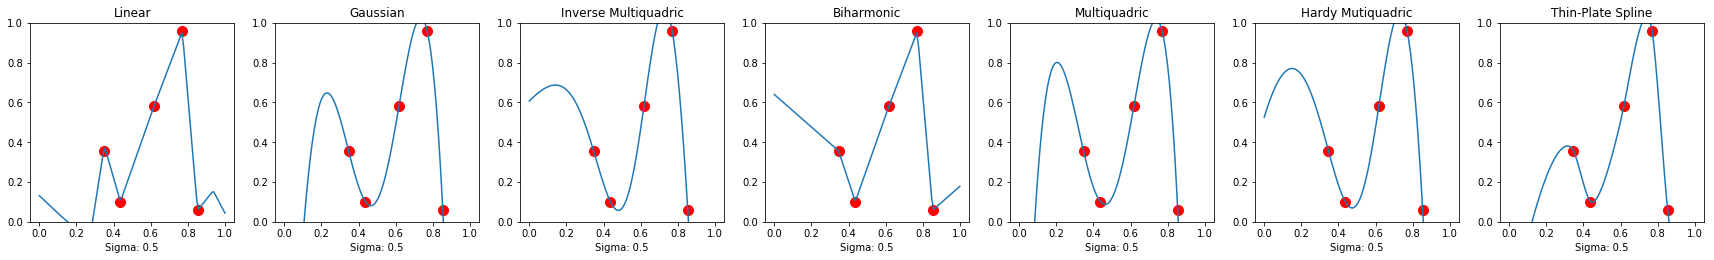

In [3]:
import sys
sys.path.append('python')

import numpy
from scatter_data_interpolation.radial_basis_function import linear
from scatter_data_interpolation.radial_basis_function import gaussian
from scatter_data_interpolation.radial_basis_function import inverse_multiquadric
from scatter_data_interpolation.radial_basis_function import biharmonic
from scatter_data_interpolation.radial_basis_function import multiquadric
from scatter_data_interpolation.radial_basis_function import hardy_multiquadric
from scatter_data_interpolation.radial_basis_function import thin_plate_spline
from scatter_data_interpolation.plot_utils import plot_1d

# generate data
n = 5
nodes = numpy.random.random((n,1))
values = numpy.random.random((n))

plot_1d([
    ('Linear', linear, 0.5), 
    ('Gaussian', gaussian, 0.5),
    ('Inverse Multiquadric', inverse_multiquadric, 0.5),
    ('Biharmonic', biharmonic, 0.5),
    ('Multiquadric', multiquadric, 0.5),
    ('Hardy Mutiquadric', hardy_multiquadric, 0.5),
    ('Thin-Plate Spline', thin_plate_spline, 0.5),
], nodes, values)

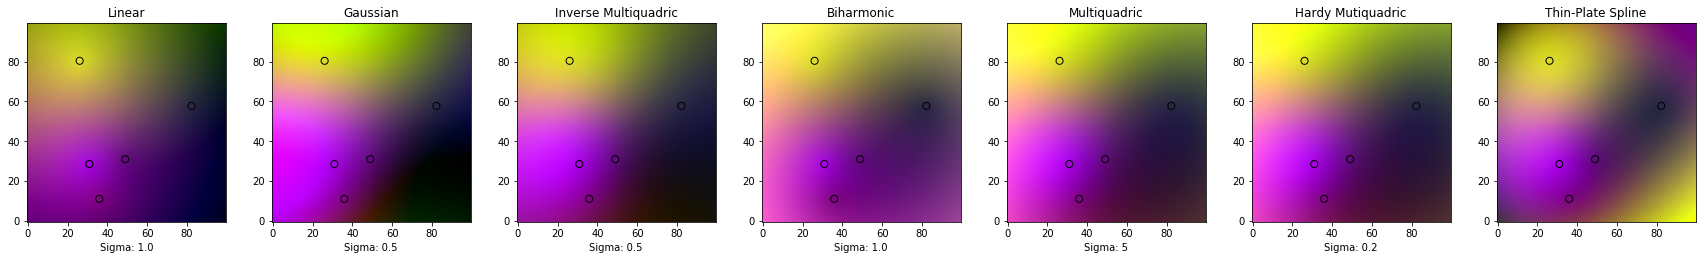

In [4]:
import sys
sys.path.append('python')

import numpy
from scatter_data_interpolation.radial_basis_function import linear
from scatter_data_interpolation.radial_basis_function import gaussian
from scatter_data_interpolation.radial_basis_function import inverse_multiquadric
from scatter_data_interpolation.radial_basis_function import biharmonic
from scatter_data_interpolation.radial_basis_function import multiquadric
from scatter_data_interpolation.radial_basis_function import hardy_multiquadric
from scatter_data_interpolation.radial_basis_function import thin_plate_spline
from scatter_data_interpolation.plot_utils import plot_2d

# generate data
n = 5
nodes = numpy.random.random((n, 2))
values = numpy.random.random((n, 3))

plot_2d([
    ('Linear', linear, 1.0), 
    ('Gaussian', gaussian, 0.5),
    ('Inverse Multiquadric', inverse_multiquadric, 0.5),
    ('Biharmonic', biharmonic, 1.0),
    ('Multiquadric', multiquadric, 5),
    ('Hardy Mutiquadric', hardy_multiquadric, 0.2),
    ('Thin-Plate Spline', thin_plate_spline, None),
], nodes, values)

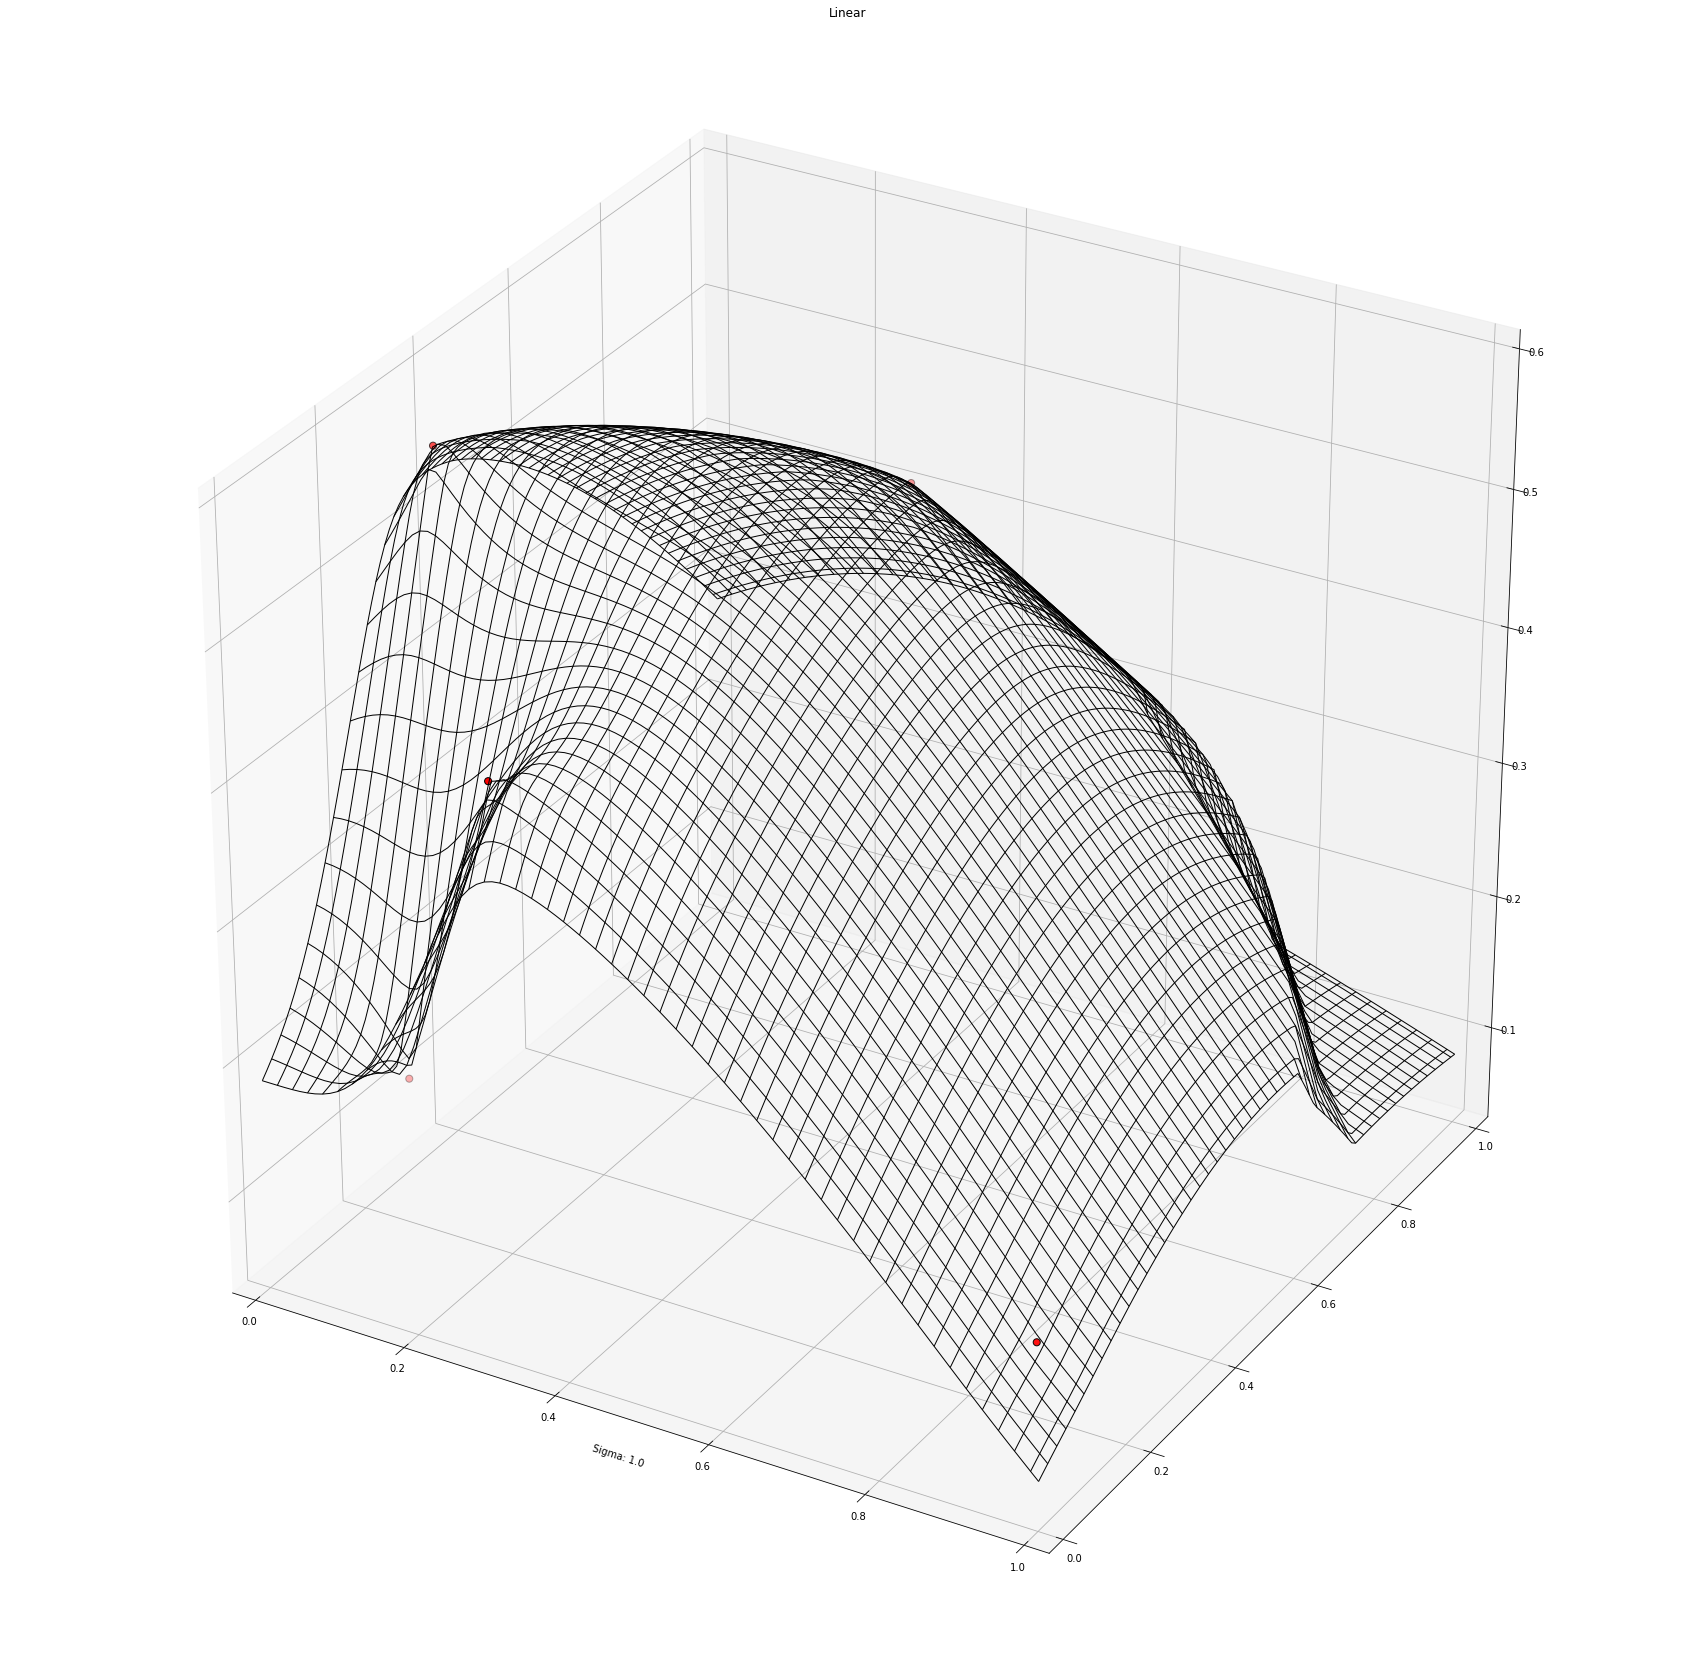

In [2]:
import sys
sys.path.append('python')

import numpy
from scatter_data_interpolation.radial_basis_function import linear
from scatter_data_interpolation.radial_basis_function import gaussian
from scatter_data_interpolation.radial_basis_function import inverse_multiquadric
from scatter_data_interpolation.radial_basis_function import biharmonic
from scatter_data_interpolation.radial_basis_function import multiquadric
from scatter_data_interpolation.radial_basis_function import hardy_multiquadric
from scatter_data_interpolation.radial_basis_function import thin_plate_spline
from scatter_data_interpolation.plot_utils import plot_3d

n = 5
nodes = numpy.random.random((n, 2))
values = numpy.random.random((n, 1))

plot_3d([
    ('Linear', linear, 1.0), 
    ('Gaussian', gaussian, 0.5),
    ('Inverse Multiquadric', inverse_multiquadric, 0.5),
    ('Biharmonic', biharmonic, 1.0),
    ('Multiquadric', multiquadric, 5),
    ('Hardy Mutiquadric', hardy_multiquadric, 0.2),
    ('Thin-Plate Spline', thin_plate_spline, None),
], nodes, values, figsize=(30, 30))